<a href="https://colab.research.google.com/github/Kalgrand/AAI_Segmentacja/blob/main/AAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

def elbow_plot(model, data):
    visualizer = KElbowVisualizer(model, k = (2,15))
    visualizer.fit(data)
    visualizer.poof()
        
def silhouette_plot(model, data):
    visualizer = SilhouetteVisualizer(model, random_state = 10)
    visualizer.fit(data)
    visualizer.poof()

1. Wczytanie danych

In [2]:
df = pd.read_csv("/content/customer.csv")
df.head()

,CustomerId;Profit;Recency;Frequency;Monetary;Variance
0,1;187;63;1;2349.06;2
1,2;96;10;6;922.62;4
2,3;47;35;4;881.22;3
3,4;294;5;1;3815.16;2
4,5;732;4;31;41868.11;29


In [3]:
df2 = pd.read_csv("/content/customer.csv", delimiter = ";")
df2.sample(5)

,CustomerId,Profit,Recency,Frequency,Monetary,Variance
715,716,194,5,8,6583.00,13
390,391,74,11,10,979.88,6
189,190,76,21,7,2874.69,10
959,960,62,48,2,235.60,1
1340,1341,1271,5,19,59923.91,34


2. Przegląd danych

In [4]:
df2.shape

(1511, 6)

Mamy 1511 wierszy i 6 kolumn.

In [5]:
df2.isnull().sum()

CustomerId    0
Profit        0
Recency       0
Frequency     0
Monetary      0
Variance      0
dtype: int64

Nie mamy pustych wartości, wszystkie wiersze są uzupełnione.

In [6]:
df2.dtypes

CustomerId      int64
Profit          int64
Recency         int64
Frequency       int64
Monetary      float64
Variance        int64
dtype: object

Wszystkie kolumny z wyjątkiem "Monetary" zawierają liczby całkowite (integer). Kolumna "Monetary" jest typu 'float', ponieważ zawiera liczby zmiennoprzecinkowe możemy ją zostawić.

3. Przygotowanie danych

In [7]:
df3 = df2.copy()
df3.Monetary = df3.Monetary.replace(to_replace = ",", value = ".", regex = True)
df3.Monetary

0         2349.06
1          922.62
2          881.22
3         3815.16
4        41868.11
          ...    
1506     15798.92
1507      2676.89
1508    109497.54
1509     49602.45
1510      1047.58
Name: Monetary, Length: 1511, dtype: float64

In [8]:
df3.Monetary = df3.Monetary.astype(float)
df3.dtypes

CustomerId      int64
Profit          int64
Recency         int64
Frequency       int64
Monetary      float64
Variance        int64
dtype: object

Zamieniam typ na float za pomocą funkcji 'astype()'. Ponieważ nie wyswietlało danych w dalszych obliczeniach.

In [9]:
df3.head()

,CustomerId,Profit,Recency,Frequency,Monetary,Variance
0,1,187,63,1,2349.06,2
1,2,96,10,6,922.62,4
2,3,47,35,4,881.22,3
3,4,294,5,1,3815.16,2
4,5,732,4,31,41868.11,29


Kolumna "CustomerId" określa konkretnego klienta. Z punktu widzenia naszych danych i późniejszej segmentacji jest ona nieistotna. Nie niesie żadnych przydatnych informacji.

In [10]:
df3 = df3.drop("CustomerId", axis = 1)

Usuwam kolumnę CostumersId

4. Rozkład danych

In [11]:
round(df3.describe(), 2)

,Profit,Recency,Frequency,Monetary,Variance
count,1511.00,1511.00,1511.00,1511.00,1511.00
mean,1102.39,15.85,10.71,175383.72,16.67
std,5457.68,19.05,10.35,1791089.07,17.70
min,1.00,1.00,1.00,15.78,1.00
25%,79.00,4.00,3.00,1398.61,5.00
50%,224.00,6.00,9.00,5799.93,11.00
75%,559.50,19.00,14.50,22289.00,23.00
max,105993.00,91.00,79.00,32539936.23,139.00


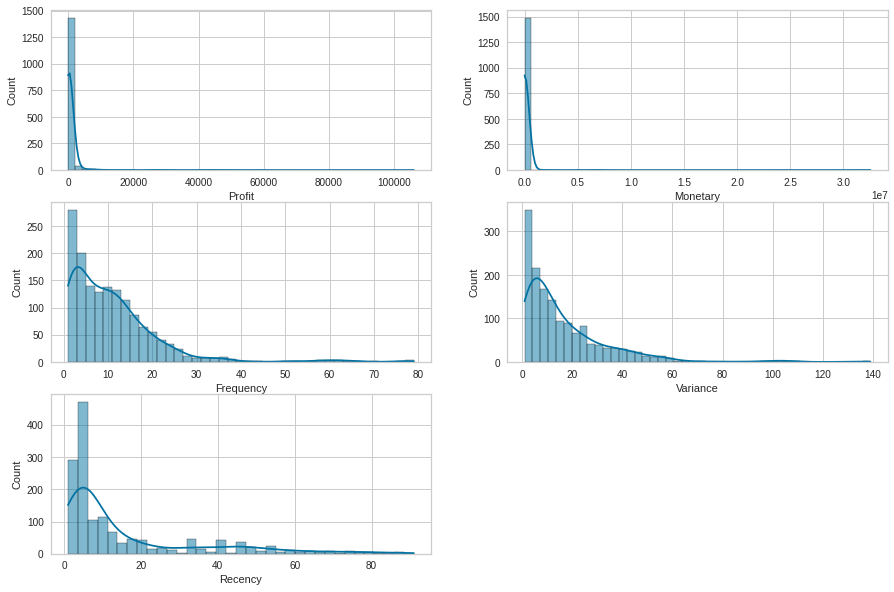

In [12]:
plt.figure(figsize = (15,10))
plt.subplot(3,2,1)
sns.histplot(x = df3.Profit, kde = True, bins = 50)
plt.subplot(3,2,2)
sns.histplot(x = df3.Monetary, kde = True, bins = 50)
plt.subplot(3,2,3)
sns.histplot(x = df3.Frequency, kde = True)
plt.subplot(3,2,4)
sns.histplot(x = df3.Variance, kde = True)
plt.subplot(3,2,5)
sns.histplot(x = df3.Recency, kde = True)

Odchylenie standardowe większe lub zbliżone do średniej oraz duża różnica między trzecim kwantylem a maksymalną wartością wskazują na występowanie długiego prawego ogona.

Aby zniwelować rozrzut danych, zlogarytmujemy dane, z racji że wszystkie wartości kolumn są dodatnie nie ma do tego przeciwskazań.

In [13]:
df3_log = np.log(df3)

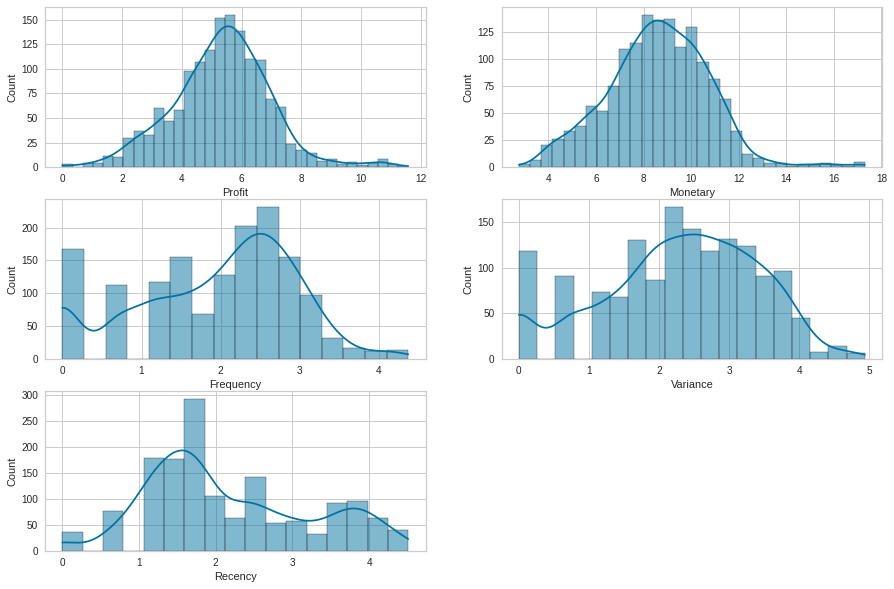

In [14]:
plt.figure(figsize = (15,10))
plt.subplot(3,2,1)
sns.histplot(x = df3_log.Profit, kde = True)
plt.subplot(3,2,2)
sns.histplot(x = df3_log.Monetary, kde = True)
plt.subplot(3,2,3)
sns.histplot(x = df3_log.Frequency, kde = True)
plt.subplot(3,2,4)
sns.histplot(x = df3_log.Variance, kde = True)
plt.subplot(3,2,5)
sns.histplot(x = df3_log.Recency, kde = True)

Rozkłady przypominają rozkład normalny.

5. Usuwanie wartości odstających.

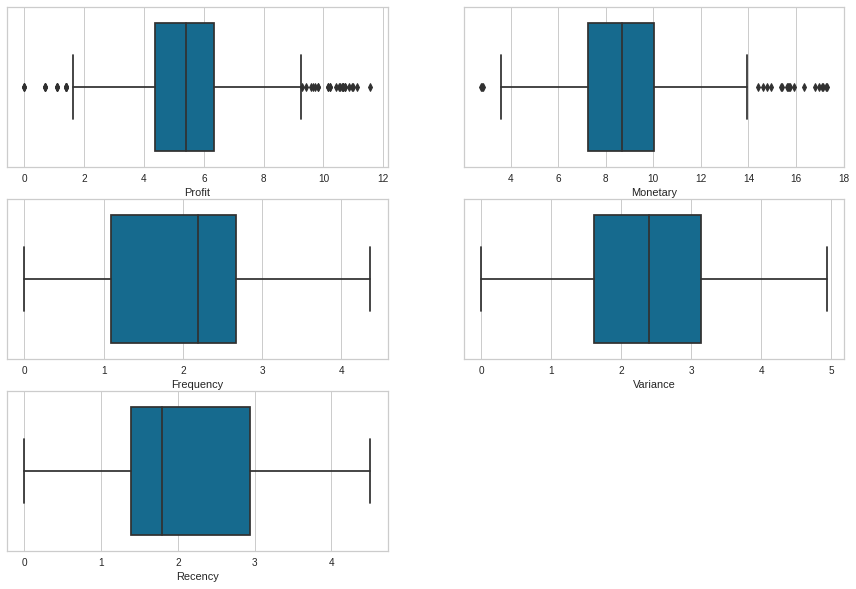

In [15]:
plt.figure(figsize = (15,10))
plt.subplot(3,2,1)
sns.boxplot(x = df3_log.Profit)
plt.subplot(3,2,2)
sns.boxplot(x = df3_log.Monetary)
plt.subplot(3,2,3)
sns.boxplot(x = df3_log.Frequency)
plt.subplot(3,2,4)
sns.boxplot(x = df3_log.Variance)
plt.subplot(3,2,5)
sns.boxplot(x = df3_log.Recency)

W kolumnach "Profit" i "Monetary" występują wartości odstające.

In [16]:
for i in ["Profit", "Monetary"]:
    q1 = df3_log[f"{i}"].quantile(0.25)
    q3 = df3_log[f"{i}"].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    df3_log = df3_log[(df3_log[f"{i}"] > low) & (df3_log[f"{i}"] < high)]

5. Standaryzacja

Sprowadzenie danych do wspólnej skali.

In [17]:
scaler = StandardScaler()
scaler.fit(df3_log)
df3_log_std = scaler.transform(df3_log)
df3_log_scaler = pd.DataFrame(data = df3_log_std, index = df3_log.index, columns = df3_log.columns)

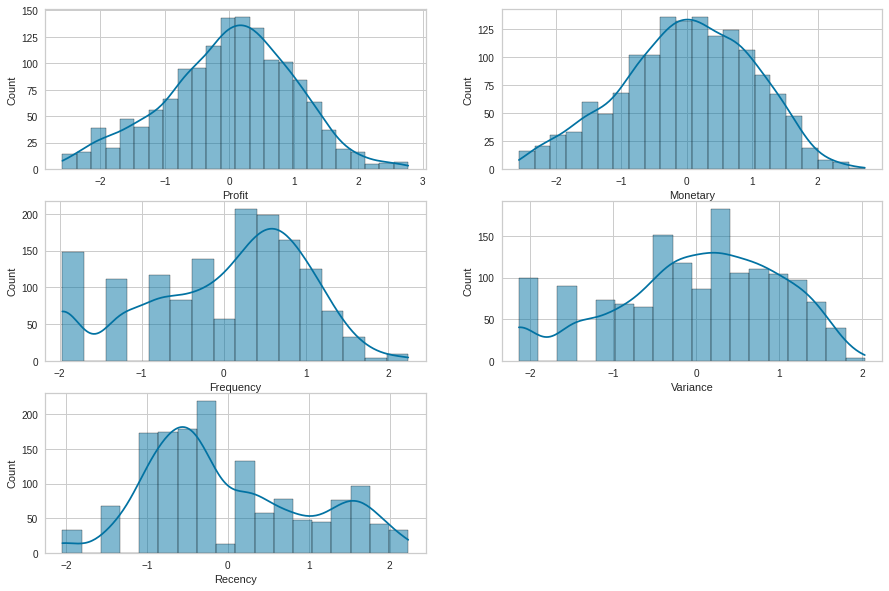

In [18]:
plt.figure(figsize = (15,10))
plt.subplot(3,2,1)
sns.histplot(x = df3_log_scaler.Profit, kde = True)
plt.subplot(3,2,2)
sns.histplot(x = df3_log_scaler.Monetary, kde = True)
plt.subplot(3,2,3)
sns.histplot(x = df3_log_scaler.Frequency, kde = True)
plt.subplot(3,2,4)
sns.histplot(x = df3_log_scaler.Variance, kde = True)
plt.subplot(3,2,5)
sns.histplot(x = df3_log_scaler.Recency, kde = True)

Możemy zauważyć bardzo duże podobieństwo rozkładu danych w kolumnach "Profit" i "Monetary" oraz w kolumnach "Frequency" i "Variance". Można przypuszczać o zależnościach kolumn.

6. Koreacja

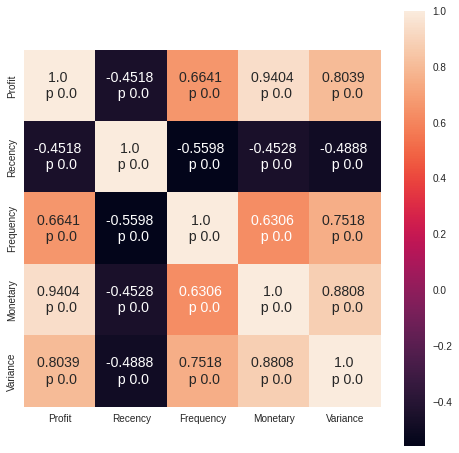

In [19]:
coef = np.around(stats.spearmanr(df3_log_scaler)[0], 4)   # Współczynniki korelacji Spearmana zaokrąglone do 4 miejsc po przecinku
pv = np.around(stats.spearmanr(df3_log_scaler)[1], 2)     # p-wartości zaokrąglone do 2 miejsc po przecinku

labels = np.asarray([f"{coef} \n p {pv}" for coef, pv in zip(coef.flatten(), pv.flatten())]).reshape(df3_log_scaler.shape[1], df3_log_scaler.shape[1])
plt.figure(figsize = (8,8))
sns.heatmap(coef, annot = labels, annot_kws = {'size': 14}, fmt = '', 
            xticklabels = df3_log.columns, yticklabels = df3_log.columns, square = True)

Wszędzie otrzymałem p-wartości mniejsze niż 0,05, zatem odrzucam hipotezę zerową o braku korelacji - dane są skorelowane. Co więcej korelacja jest bardzo duża. Największe dotyczą kolumn:

"Monetary" i "Profit" - im wyższa wartość zakupionych 
produktów, tym lepsze profity

"Variance" i "Monetary" - im więcej różnorodnych produktów klient kupił, tym wyższa wartość zakupionych produktów

"Variance" i "Profit" - im więcej różnorodnych produktów klient kupił, tym lepsze profity

Kolumna "Recency" jest ujemnie skorelowana z pozostałymi kolumnami. Oznacza to, że im mniej dni upłyneło od ostatniego zamówienia, tym większe pozostałe wskaźniki.

7. Redukcja wymiarów PCA

Przyda się do porównania segmentacji "danych oryginalnych" i "zredukowanych".

In [20]:
pca = PCA(random_state = 10)
pca.fit_transform(df3_log_scaler)

np.cumsum(pca.explained_variance_ratio_)  # Procent skumulowanej wariancji wyznaczony przez k składowych

array([0.74893186, 0.88710157, 0.9581345 , 0.99422149, 1.        ])

Zredukuje dane do dwóch wymiarów



In [21]:
pca = PCA(n_components = 2, random_state = 10)
df3_log_scaler_pca = pca.fit_transform(df3_log_scaler)

Rozkład kolumn na płaszczyźnie

In [22]:
column_names = df3_log_scaler.columns
df_pca = pd.DataFrame({"PCA 1": pca.components_[0], "PCA 2": pca.components_[1], "Features": column_names})
df_pca

,PCA 1,PCA 2,Features
0,-0.468685,0.355645,Profit
1,0.351252,0.822433,Recency
2,-0.442979,-0.237320,Frequency
3,-0.479303,0.356314,Monetary
4,-0.480619,0.117642,Variance


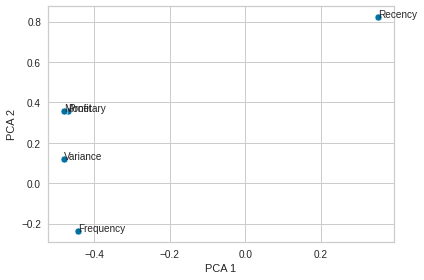

In [23]:
# Wykres

sns.scatterplot(x = df_pca["PCA 1"], y = df_pca["PCA 2"])
for i, txt in enumerate(df_pca.Features):
    plt.annotate(txt, (df_pca["PCA 1"][i], df_pca["PCA 2"][i]))
plt.tight_layout()
plt.show()

Wszystkie kolumny z wyjątkiem "Recency" mają zbliżoną pierwszą współrzędną PCA 1 - leżą na jednej prostej. Kolumny "Profit" i "Monetary" prawie pokrywają się - są bardzo mocno skorelowane. Kolumna "Recency" bardzo odbiega współrzędną PCA 1 od reszty kolumn. Najsilniej skorelowana jest z "Frequency", dlatego jest od niej najbardziej oddalona na wykresie.

8. Segmentacja

Za pomocą segmentacji sprawdzam jak wygląda struktura danych wejściowych oraz czy występuje w nich czynnik pozwalający na ich grupowanie. Jest to jedna z metod nienadzorowanej analizy danych. Jej celem jest podział danych na grupy, tak aby każdy z nich zawierał możliwie „podobne do siebie” elementy, a jednocześnie aby były one jak najbardziej zróżnicowane pomiędzy sobą.

Algorytmy jakich użyje:
KMeans
Birch
Segmentacja hierarchiczna

8.1 KMeans

In [24]:
distortion_score = []    # Suma kwadratów odległości danych od środka grupy dla poszczególnych k
cluster_range = range(1, 15)
for i in cluster_range:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df3_log_scaler)
    distortion_score.append(kmeans.inertia_)

Text(0, 0.5, 'distortion score')

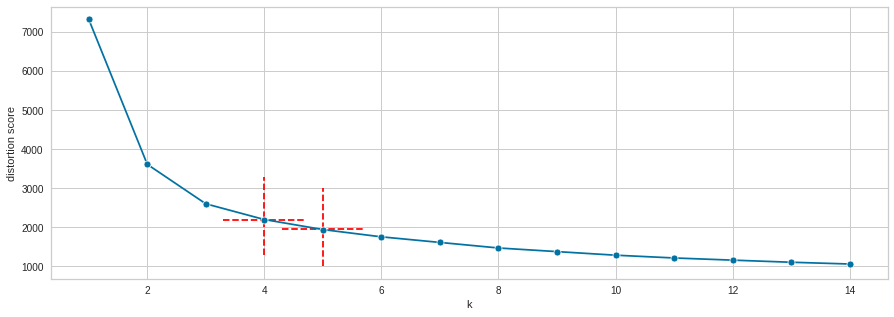

In [25]:
# Wykres łokcia

plt.figure(figsize = (15,5))
sns.lineplot(x = cluster_range, y = distortion_score, marker = "o")
plt.vlines(x = 5, ymin = 1000, ymax = 3000, linestyles = "dashed", colors = "red")
plt.vlines(x = 4, ymin = 1300, ymax = 3300, linestyles = "dashed", colors = "red")
plt.hlines(y = 1947, xmin = 4.3, xmax = 5.7,linestyles = "dashed", colors = "red")
plt.hlines(y = 2200, xmin = 3.3, xmax = 4.7,linestyles = "dashed", colors = "red")
plt.xlabel("k")
plt.ylabel("distortion score")

Jest dwóch kandydatów: k = 4 i k = 5.

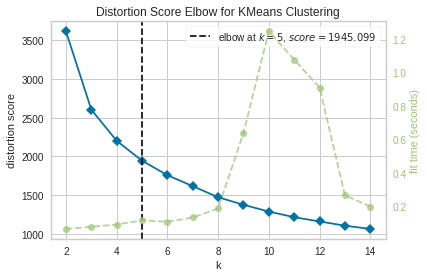

In [26]:
elbow_plot(KMeans(), df3_log_scaler)

Algorytm wskazał k = 5 jako najlepszy. Zatem dane podziele na 5 grup.

Do sprawdzenia rozkładu grup, użyje 'SilhouetteVisualizer()'

---



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


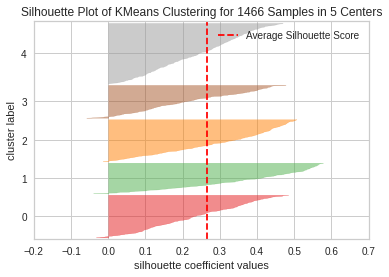

In [27]:
kmeans = KMeans(n_clusters = 5, random_state = 10)
kmeans.fit(df3_log_scaler)
silhouette_plot(kmeans, df3_log_scaler)

Uśredniony silhouette score niezbyt duży.

In [28]:
k_means_silhouette_avg = silhouette_score(df3_log_scaler, kmeans.labels_)
k_means_silhouette_avg

0.26494303551890075

In [29]:
kmeans_sum = pd.Series(kmeans.labels_).value_counts()
kmeans_sum

4    425
0    300
2    295
3    231
1    215
dtype: int64

Algorytm podzielił dane mniej więcej po równo.

8.2. KMeans PCA

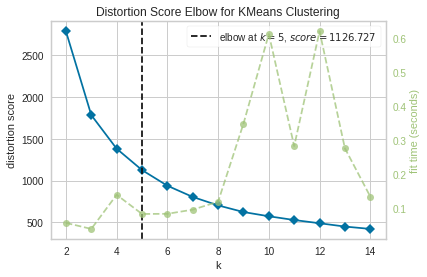

In [30]:
elbow_plot(KMeans(), df3_log_scaler_pca)

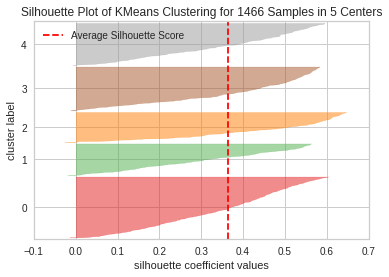

In [31]:
kmeans_pca = KMeans(n_clusters = 5, random_state = 10)
kmeans_pca.fit(df3_log_scaler_pca)
silhouette_plot(kmeans_pca, df3_log_scaler_pca)

Lepszy wynik silhouette niż wyżej.

In [32]:
k_means_pca_silhouette_avg = silhouette_score(df3_log_scaler_pca, kmeans_pca.labels_)
k_means_pca_silhouette_avg

0.36319179649849104

In [33]:
kmeans_pca_sum = pd.Series(kmeans_pca.labels_).value_counts()
kmeans_pca_sum

0    428
3    309
4    296
1    222
2    211
dtype: int64

Podobnie jak poprzednio

8.3. Brich

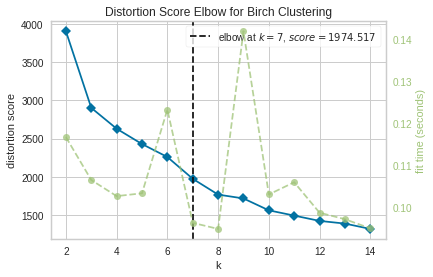

In [34]:
elbow_plot(Birch(), df3_log_scaler)

Algorytm wskazał k = 7 jako najlepszy. Zatem dane podziele na 7 grup.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


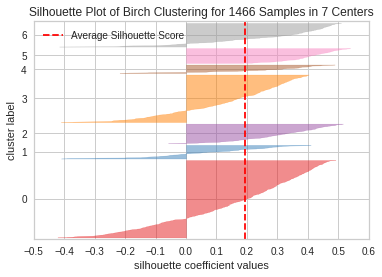

In [35]:
birch = Birch(n_clusters = 7)
birch.fit(df3_log_scaler)
silhouette_plot(birch, df3_log_scaler)

Dużo ujemnych współczynnkików silhouette. Nie jest to dobry model.

In [36]:
birch_silhouette_avg = silhouette_score(df3_log_scaler, birch.labels_)
birch_silhouette_avg

0.19337055145127852

In [37]:
birch_sum = pd.Series(birch.labels_).value_counts()
birch_sum

0    551
3    339
6    169
2    141
5    107
1     98
4     61
dtype: int64

8.4. Brich PCA

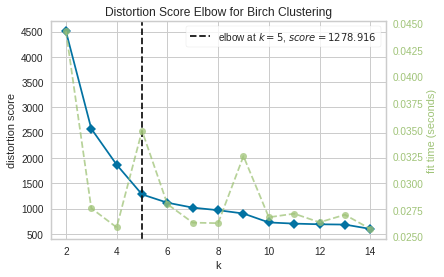

In [38]:
elbow_plot(Birch(), df3_log_scaler_pca)

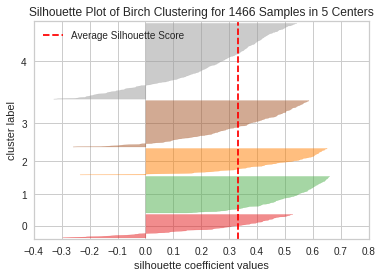

In [39]:
birch_pca = Birch(n_clusters = 5)
birch_pca.fit(df3_log_scaler_pca)
silhouette_plot(birch_pca, df3_log_scaler_pca)

Lepiej niż bez PCA, ale nadal występują ujemne współczynniki silhouette.

In [40]:
birch_pca_silhouette_avg = silhouette_score(df3_log_scaler_pca, birch_pca.labels_)
birch_pca_silhouette_avg

0.3308271377198257

In [41]:
birch_pca_sum = pd.Series(birch_pca.labels_).value_counts()
birch_pca_sum

4    532
3    326
1    257
2    186
0    165
dtype: int64

8.5. Segmentacja hierarchiczna

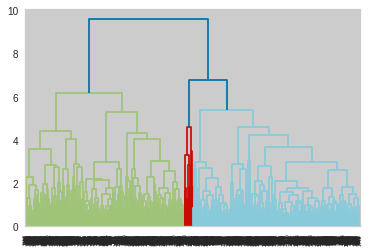

In [42]:
cl_mergings = linkage(df3_log_scaler, method = "complete")
dendrogram(cl_mergings)
plt.show()

Podziele dane na 3 grupy

In [43]:
sg_labels = fcluster(cl_mergings, 3, criterion = "maxclust")

In [44]:
sg_silhouette_avg = silhouette_score(df3_log_scaler, sg_labels)
sg_silhouette_avg

0.3022420607664996

In [45]:
sg_sum = pd.Series(sg_labels).value_counts()
sg_sum

3    731
1    696
2     39
dtype: int64

8.6. Segmentacja hierarchiczna PCA

In [46]:
cl_mergings_pca = linkage(df3_log_scaler_pca, method = "complete")

sg_pca_labels = fcluster(cl_mergings_pca, 3, criterion = "maxclust")

sg_pca_silhouette_avg = silhouette_score(df3_log_scaler_pca, sg_pca_labels)
sg_pca_silhouette_avg

0.3052108164066755

In [47]:
sg_pca_sum = pd.Series(sg_pca_labels).value_counts()
sg_pca_sum

3    750
1    525
2    191
dtype: int64

8.7. Podsumowanie segmentacji

In [48]:
sum_seg = pd.DataFrame(data = {"Silhouette Score": [k_means_silhouette_avg, k_means_pca_silhouette_avg, birch_silhouette_avg,
                                             birch_pca_silhouette_avg, sg_silhouette_avg, sg_pca_silhouette_avg],
                               "Liczba grup wyznaczona przez metodę łokcia": [kmeans_sum.size, kmeans_pca_sum.size, 
                                                                              birch_sum.size, birch_pca_sum.size,
                                                                              sg_sum.size, sg_pca_sum.size]
                              },
                       index = ["KMeans", "KMeans PCA", "Birch", "Birch PCA", "Segmentacja Hierarchiczna", "Segmentacja Hierarchiczna PCA"]
                       )
sum_seg.sort_values(by = "Silhouette Score", ascending = False)

,Silhouette Score,Liczba grup wyznaczona przez metodę łokcia
KMeans PCA,0.363192,5
Birch PCA,0.330827,5
Segmentacja Hierarchiczna PCA,0.305211,3
Segmentacja Hierarchiczna,0.302242,3
KMeans,0.264943,5
Birch,0.193371,7


Najlepszy wynik Silhouette otrzymał model KMeans PCA.

9. Analiza segmentów

Rozkład danych na płaszczyźnie podzielonych na segmenty.

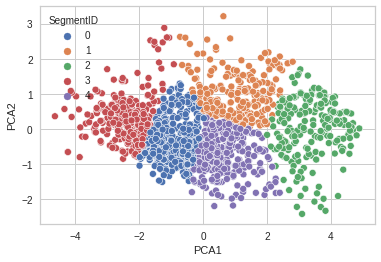

In [49]:
coordinates = pd.DataFrame(data = df3_log_scaler_pca, columns = ["PCA1", "PCA2"])
coordinates.loc[:, "SegmentID"] = kmeans_pca.labels_
sns.scatterplot(x = "PCA1", y = "PCA2", data = coordinates, hue = "SegmentID", palette = "deep")

Nowa kolumna, w której będą przechowywane identyfikatory grup.

In [50]:
df3_log_scaler.loc[:, "SegmentID"] = kmeans_pca.labels_

Zależności kolumn z podziałem na grupy.

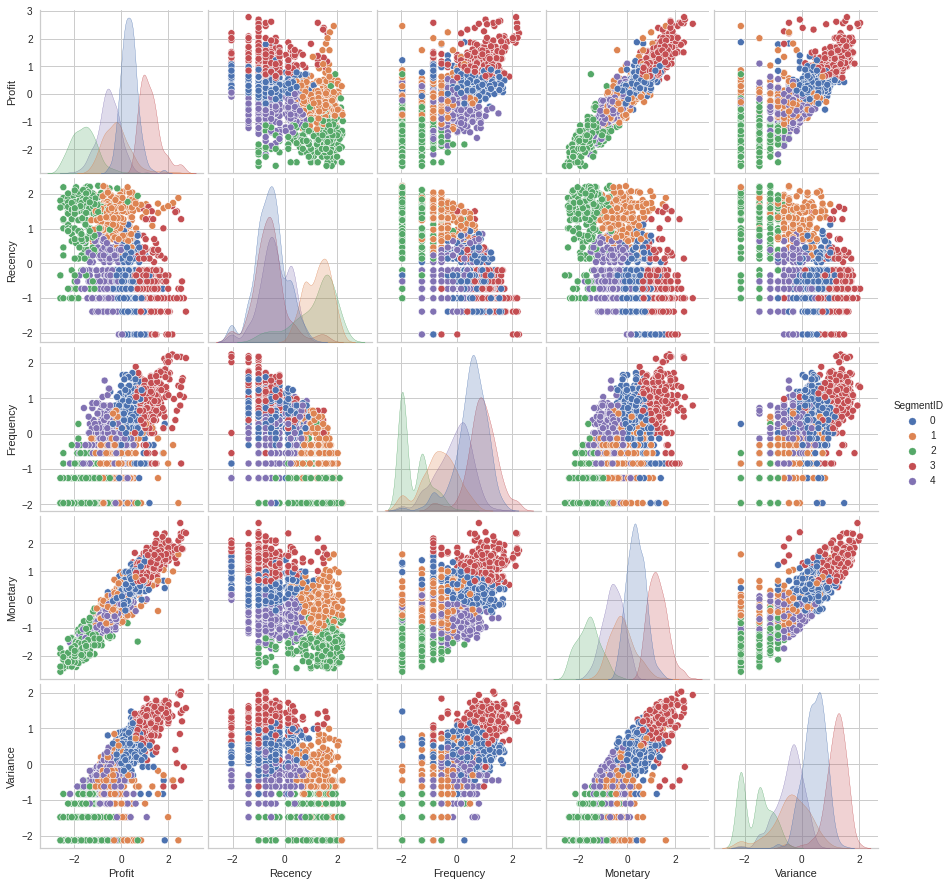

In [51]:
sns.pairplot(df3_log_scaler, hue = "SegmentID", palette = "deep")

In [52]:
df3_log_scaler.groupby(by = "SegmentID").mean()

,Profit,Recency,Frequency,Monetary,Variance
SegmentID,,,,,
0,0.340136,-0.550979,0.517460,0.370332,0.427646
1,-0.174221,1.267764,-0.633979,-0.188655,-0.379442
2,-1.579785,1.149530,-1.569820,-1.594827,-1.611453
3,1.241037,-0.589833,0.909471,1.267385,1.188013
4,-0.530565,-0.357828,-0.103123,-0.580182,-0.425257


Analiza danych: 

0 (niebiescy): Klienci bardzo często powracający (ujemne Recency), kupujący dużo (Monetary i Variance), przynoszący korzyści sklepowi (Profit).

1 (pomarańczowi): Klienci najrzadziej powracający (najwyższe Recency), kupujący niezbyt wiele (ujemne Manetary i Variance).

2 (zieloni): Klienci z największymi korzyściami dla sklepu (najwyższy Profit), najczęściej składający zamówienia (najniższe Recency, najwyższe Frequency), zamawiający najwięcej różnych produktów (najwyższe Monetary i Variance).

3 (czerwoni): Do tej grupy należą klienci, których wartość zamówionych produktów jest niska (ujemne Monetary) i którzy kupują mało różnorodnych produktów (ujemne Variance). Jednak dosyć regularnie powracają i składają zamówienia (ujemne Recency).

4 (fioletowi): Tutaj mamy klientów, którzy bardzo mało kupują (najniższe Monetary i najniższe Variance) i bardzo rzadko (najniższe Frequency). Przynoszą najmniejsze korzyści dla sklepu (najniższe Profit).

In [53]:
# Łączę tabele i usuwam niepotrzebne kolumny

df_final = pd.concat([df3_log_scaler, df2], axis = 1, ignore_index = True).drop([0,1,2,3,4], axis = 1)

# Nadaję kolumnom nazwy

df_final.columns = ["SegmentID", "CustomerID", "Profit", "Recency", "Frequency", "Monetary", "Variance"]

# Wypełniam nulle w kolumnie "SegmentID" 
# (rekordów jest więcej niż w kolumnie "SegmentID", ponieważ usunęliśmy wartości odstające)

df_final.SegmentID = df_final.SegmentID.fillna('odstający')

# Przestawiam kolumnę "SegmentID" na koniec tabeli

df_final = pd.DataFrame(df_final, columns = ["CustomerID", "Profit", "Recency", "Frequency", "Monetary", "Variance", "SegmentID"])

# Dodaję nazwy grup

df_final.loc[df_final.SegmentID == 0, "SegmentName"] = "Niebiescy"
df_final.loc[df_final.SegmentID == 1, "SegmentName"] = "Pomarańczowi"
df_final.loc[df_final.SegmentID == 2, "SegmentName"] = "Zieloni"
df_final.loc[df_final.SegmentID == 3, "SegmentName"] = "Czerwoni"
df_final.loc[df_final.SegmentID == 4, "SegmentName"] = "Fioletowi"
df_final.loc[df_final.SegmentID == 'odstający', "SegmentName"] = "Odstający"

In [54]:
df_final.sample(5, random_state = 35)

,CustomerID,Profit,Recency,Frequency,Monetary,Variance,SegmentID,SegmentName
298,299,132,19,2,759.92,2,2,Zieloni
703,704,87,56,5,1863.75,6,1,Pomarańczowi
1242,1243,457,3,14,11091.38,18,0,Niebiescy
238,239,36,9,3,783.37,5,4,Fioletowi
534,535,997,6,15,54749.65,48,3,Czerwoni


Wygląd oryginalnych danych z podziałem na grupy.

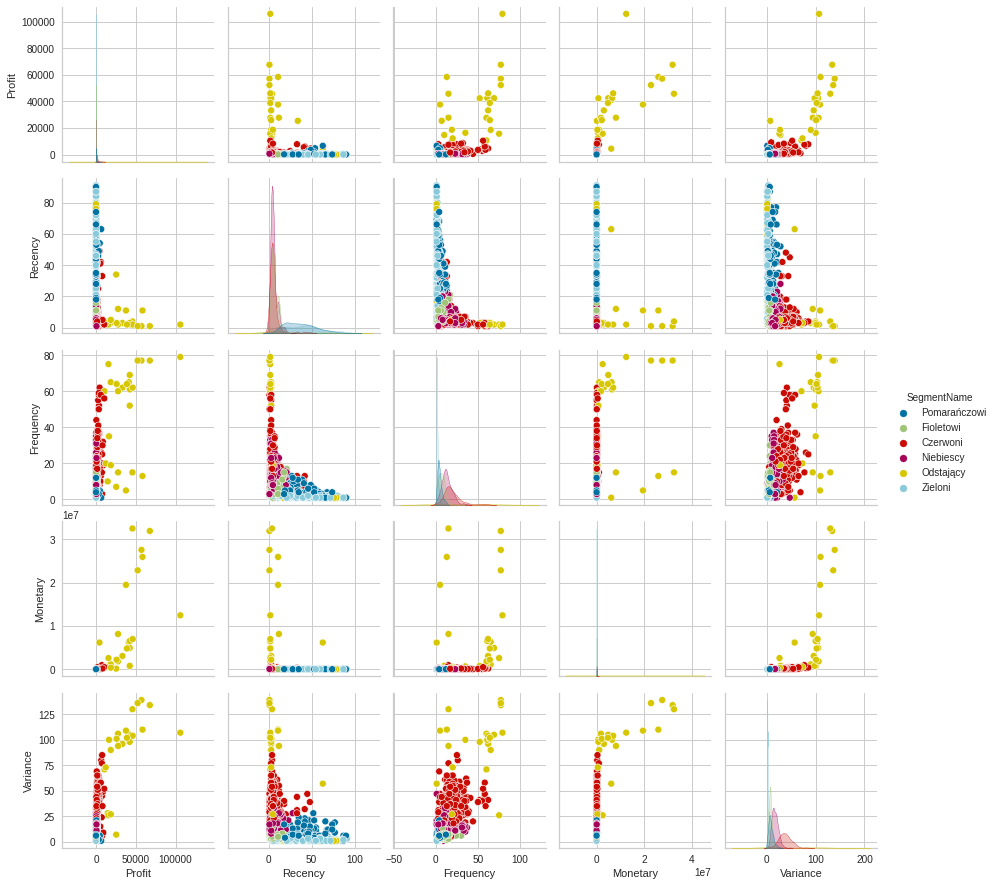

In [55]:
df_org = pd.concat([df3, df_final.SegmentName], axis = 1)
sns.pairplot(df_org, hue = "SegmentName")